# Deep learning NER

In this notebook, we will discover two deep learning techniques for Named Entity Recognition (or NER).

- LSTM (Long Short Term Memory)
- Transformers


The generated **BIO** file by the script will be loaded as well as a corpus of lambda sentences that don't necessarily contain either an _arrival_ or _departure_ location.

Since the goal is to extract the locations from a user's query, the times in which random sentences might be inputted should be accounted for. Therefore, to stay rational with the frequency of that happening, the ratio will be $1:10$ for the lambda sentences which will be extracted from `data/french_text/1k_unlabeled_samples.txt`. In addition, more complex sentences where the **departure** and **arrival** locations are not in the same sentence. Their ratio will be the same as the unlabeled sentences.


## Sentence Loading and Preprocessing


In [2]:
from app.travel_resolver.libs.nlp import data_processing as dp

sentences, labels, vocab, unique_labels = dp.from_bio_file_to_examples(
    "./data/bio/fr.bio/10k_train_small_samples.bio"
)

[nltk_data] Downloading package punkt_tab to /Users/az-r-
[nltk_data]     ow/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
lambda_sentences, lambda_labels, _, __ = dp.from_bio_file_to_examples(
    "./data/bio/fr.bio/1k_train_unlabeled_samples.bio"
)

In [4]:
large_sentences, large_labels, _, __ = dp.from_bio_file_to_examples(
    "./data/bio/fr.bio/1k_train_large_samples.bio"
)

In [5]:
sentences = sentences + lambda_sentences + large_sentences
labels = labels + lambda_labels + large_labels

In [6]:
def process_sentences_and_labels(
    sentences,
    labels,
    rm_stopwords: bool = False,
    stemming: bool = True,
    return_tokens: bool = False,
):
    """
    Process the sentences and labels using the process_sentence function from the data_processing module.

    Args:
    sentences (list): List of sentences to process.
    labels (list): List of labels to process.
    rm_stopwords (bool): Whether to remove stopwords from the sentences.
    stemming (bool): Whether to apply stemming to the sentences.
    return_tokens (bool): Whether to return the tokens of the sentences.

    Returns:
    processed_sentences (list): List of processed sentences.
    processed_labels (list): List of processed labels.
    """
    processed_sentences = []
    processed_labels = []

    for sentence, label in zip(sentences, labels):
        sentence, label = dp.process_sentence(
            sentence,
            labels_to_adapt=label,
            rm_stopwords=rm_stopwords,
            stemming=stemming,
            return_tokens=return_tokens,
        )
        processed_sentences.append(sentence)
        processed_labels.append(label)

    return processed_sentences, processed_labels

In [7]:
processed_sentences, processed_labels = process_sentences_and_labels(
    sentences, labels, return_tokens=True
)

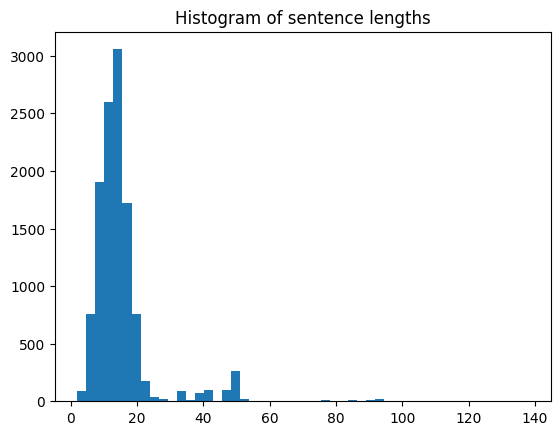

In [8]:
import matplotlib.pyplot as plt

plt.hist([len(sentence) for sentence in processed_sentences], bins=50)
plt.title("Histogram of sentence lengths")

plt.show()

In [9]:
"""
  This variable will control the maximum length of the sentence 
  as well as the embedding size
"""

MAX_LEN = 100

### Stanza Pipeline for POS


In [14]:
import stanza

nlp = stanza.Pipeline(
    "fr", processors="tokenize,pos", use_gpu=True, pos_batch_size=3000
)

2024-12-29 19:18:12 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-12-29 19:18:12 INFO: Downloaded file to /Users/az-r-ow/stanza_resources/resources.json
2024-12-29 19:18:12 WARNING: Language fr package default expects mwt, which has been added
2024-12-29 19:18:12 INFO: Loading these models for language: fr (French):
| Processor | Package         |
-------------------------------
| tokenize  | combined        |
| mwt       | combined        |
| pos       | combined_charlm |

2024-12-29 19:18:12 WARNING: GPU requested, but is not available!
2024-12-29 19:18:12 INFO: Using device: cpu
2024-12-29 19:18:12 INFO: Loading: tokenize
/Users/az-r-ow/Developer/TravelOrderResolver/venv/lib/python3.12/site-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default valu

In [15]:
docs = [stanza.Document([], text=sentence) for sentence in sentences]

pos_tags_docs = nlp(docs)

In [16]:
def get_sentences_pos_tags(sentences: list[str]):
    """
    Get the POS tags of the words in the sentences.

    Args:
    sentences (list): List of sentences to get the POS tags from.

    Returns:
    pos_tags (list): List of POS tags for each sentence.
    """
    docs = [stanza.Document([], text=sentence) for sentence in sentences]
    pos_tags_docs = nlp(docs)

    sentences_pos_tags = []
    for doc in pos_tags_docs:
        sentences_pos_tags.append([word.upos for word in doc.sentences[0].words])

    return sentences_pos_tags

In [17]:
pos_tags_sentences = []

for doc in pos_tags_docs:
    pos_tags_sentences.append([word.upos for word in doc.sentences[0].words])

In [18]:
all_pos_tags = []

for doc in pos_tags_docs:
    pos_tags = [word.upos for sent in doc.sentences for word in sent.words]
    all_pos_tags.extend(pos_tags)

In [19]:
unique_pos_tags = sorted(set(all_pos_tags))

unique_pos_tags

['ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SYM',
 'VERB',
 'X']

### Generating inputs


In [10]:
import tensorflow as tf


def encode_and_pad_sentence(sentence: str, vocab: list[str], max_length: int = MAX_LEN):
    """
    Encode a sentence into a list of integers

    Parameters:
    sentence (str): The sentence to encode
    vocab (list): The vocabulary

    Returns:
    list: The list of integers
    """
    encoded_sentence = [
        vocab.index(word) if word in vocab else vocab.index("<UNK>")
        for word in sentence
    ]

    return tf.keras.utils.pad_sequences(
        [encoded_sentence], maxlen=max_length, padding="post", value=0
    )[0]

In [20]:
def encode_and_pad_sentence_pos(
    sentence_pos: str, pos_tags: list[str] = unique_pos_tags, max_length: int = MAX_LEN
):
    """
    Encode a sentence into a list of integers

    Parameters:
    sentence (str): The sentence to encode
    pos_tags (list): The vocabulary

    Returns:
    list: The list of integers
    """
    encoded_sentence = [pos_tags.index(pos) for pos in sentence_pos]

    return tf.keras.utils.pad_sequences(
        [encoded_sentence], maxlen=max_length, padding="post", value=0
    )[0]

In [21]:
get_vocab_from_corpus = lambda corpus: ["", "<UNK>"] + list(
    set([word for sentence in corpus for word in sentence])
)

In [22]:
vocab = get_vocab_from_corpus(processed_sentences)

In [23]:
encoded_sentences = [
    encode_and_pad_sentence(sentence, vocab) for sentence in processed_sentences
]

In [24]:
pos_tags_sentences = [
    encode_and_pad_sentence_pos(sentence_pos) for sentence_pos in pos_tags_sentences
]

In [25]:
padded_labels = tf.keras.preprocessing.sequence.pad_sequences(
    processed_labels, maxlen=MAX_LEN, padding="post", value=-1
)

In [26]:
dataset = tf.data.Dataset.from_tensor_slices((encoded_sentences, padded_labels))

dataset = dataset.shuffle(len(encoded_sentences), seed=42)

# Split the dataset into a training and testing dataset
train_dataset, test_dataset = tf.keras.utils.split_dataset(dataset, left_size=0.8)

2024-12-29 19:19:50.647172: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
pos_dataset = tf.data.Dataset.from_tensor_slices(
    ((encoded_sentences, pos_tags_sentences), padded_labels)
)


pos_dataset = pos_dataset.shuffle(len(encoded_sentences), seed=42)

pos_train_dataset, pos_test_dataset = tf.keras.utils.split_dataset(
    pos_dataset, left_size=0.8
)

2024-12-29 19:19:51.603887: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Masked loss and metrics

Before training the model, we need to create your own function to compute the accuracy. Tensorflow has built-in accuracy metrics but we cannot pass values to be ignored. This will impact the calculations, since we must remove the padded values.

Usually, the metric that inputs true labels and predicted labels and outputs how many times the predicted and true labels match is called accuracy. In some cases, however, there is one more step before getting the predicted labels. This may happen if, instead of passing the predicted labels, a vector of probabilities is passed. In such case, there is a need to perform an `argmax` for each prediction to find the appropriate predicted label. Such situations happen very often, therefore Tensorflow has a set of functions, with prefix `Sparse`, that performs this operation in the backend. Unfortunately, it does not provide values to ignore in the accuracy case. This is what you will work on now.

Note that the model's prediction has 3 axes:

- the number of examples (batch size)
- the number of words in each example (padded to be as long as the longest sentence in the batch)
- the number of possible targets (the 17 named entity tags).

Another important function is the loss function. In this case, we will use the Cross Entropy loss, but we need a multiclass implementation of it, also we may look for its Sparse version. Tensorflow has a SparseCategoricalCrossentropy loss function, which it is already imported by the name SparseCategoricalCrossEntropy.

SparseCategoricalCrossentropy: The Sparse Categorical Crossentropy Loss Function.

The arguments you will need:

1. `from_logits`: This indicates if the values are raw values or normalized values (probabilities). Since the last layer of the model finishes with a LogSoftMax call, the results are not normalized - they do not lie between 0 and 1.
2. `ignore_class`: This indicates which class should be ignored when computing the crossentropy. Remember that the class related to padding value is set to be 0.


In [154]:
class CustomSparseCategoricalCrossentropy(tf.keras.losses.Loss):
    def __init__(self, from_logits=False, ignore_class=-1):
        super().__init__()
        self.from_logits = from_logits
        self.ignore_class = ignore_class

    def call(self, y_true, y_pred):
        # Ensure inputs are tensors
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)

        # Generate a mask that is False where y_true equals ignore_class and True elsewhere
        mask = tf.not_equal(y_true, self.ignore_class)

        # Use this mask to filter out ignored values from y_true and y_pred
        y_true_filtered = tf.boolean_mask(y_true, mask)
        y_pred_filtered = tf.boolean_mask(y_pred, mask)

        # Compute the sparse categorical crossentropy on filtered targets and predictions
        loss = tf.keras.losses.sparse_categorical_crossentropy(
            y_true_filtered, y_pred_filtered, from_logits=self.from_logits
        )

        # Return the mean loss value
        return tf.reduce_mean(loss)


def masked_loss(y_true, y_pred):
    """
    Calculate the masked sparse categorical cross-entropy loss.

    Parameters:
    y_true (tensor): True labels.
    y_pred (tensor): Predicted logits.

    Returns:
    loss (tensor): Calculated loss.
    """

    # Calculate the loss for each item in the batch. Remember to pass the right arguments, as discussed above!
    loss_fn = CustomSparseCategoricalCrossentropy(from_logits=True, ignore_class=-1)
    # Use the previous defined function to compute the loss
    loss = loss_fn(y_true, y_pred)

    return loss

In [155]:
def masked_accuracy(y_true, y_pred):
    """
    Calculate masked accuracy for predicted labels.

    Parameters:
    y_true (tensor): True labels.
    y_pred (tensor): Predicted logits.

    Returns:
    accuracy (tensor): Masked accuracy.
    """

    # Calculate the loss for each item in the batch.
    # We must always cast the tensors to the same type in order to use them in training. Since we will make divisions, it is safe to use tf.float32 data type.
    y_true = tf.cast(y_true, tf.float32)
    # Create the mask, i.e., the values that will be ignored
    mask = tf.not_equal(y_true, -1.0)

    mask = tf.cast(mask, tf.float32)

    # Perform argmax to get the predicted values
    y_pred_class = tf.math.argmax(y_pred, axis=-1)
    y_pred_class = tf.cast(y_pred_class, tf.float32)
    # Compare the true values with the predicted ones
    matches_true_pred = tf.equal(y_true, y_pred_class)
    matches_true_pred = tf.cast(matches_true_pred, tf.float32)
    # Multiply the acc tensor with the masks
    matches_true_pred *= mask

    # Compute masked accuracy (quotient between the total matches and the total valid values, i.e., the amount of non-masked values)
    masked_acc = tf.reduce_sum(matches_true_pred) / tf.reduce_sum(mask)

    return masked_acc

In addition, we will need a function that computes the accuracy of the model when it comes to the tagged entities. This will come in handy when comparing the performance of the models on sentences with different length. Because otherwise, using the `masked_accuracy` the score will be biases (because of the `O` token).


In [156]:
def entity_accuracy(y_true, y_pred):
    """
    Calculate the accuracy based on the entities. Which mean that correct `O` tags will not be taken into account.

    Parameters:
    y_true (tensor): True labels.
    y_pred (tensor): Predicted logits.

    Returns:
    accuracy (tensor): Tag accuracy.
    """

    y_true = tf.cast(y_true, tf.float32)
    # We ignore the padding and the O tag
    mask = y_true > 0
    mask = tf.cast(mask, tf.float32)

    y_pred_class = tf.math.argmax(y_pred, axis=-1)
    y_pred_class = tf.cast(y_pred_class, tf.float32)

    matches_true_pred = tf.equal(y_true, y_pred_class)
    matches_true_pred = tf.cast(matches_true_pred, tf.float32)

    matches_true_pred *= mask

    masked_acc = tf.reduce_sum(matches_true_pred) / tf.reduce_sum(mask)

    return masked_acc

## Eval Dataset


In [28]:
eval_sentences, eval_labels, _, __ = dp.from_bio_file_to_examples(
    "./data/bio/fr.bio/800_eval_small_samples.bio"
)

eval_unlabeled, eval_unlabeled_labels, _, __ = dp.from_bio_file_to_examples(
    "./data/bio/fr.bio/eval_unlabeled_samples.bio"
)

eval_large, eval_large_labels, _, __ = dp.from_bio_file_to_examples(
    "./data/bio/fr.bio/100_eval_large_samples.bio"
)

eval_short_sentences, eval_short_labels = process_sentences_and_labels(
    eval_sentences, eval_labels, return_tokens=True
)
eval_unlabeled_sentences, eval_unlabeled_labels = process_sentences_and_labels(
    eval_unlabeled, eval_unlabeled_labels, return_tokens=True
)
eval_large_sentences, eval_large_labels = process_sentences_and_labels(
    eval_large, eval_large_labels, return_tokens=True
)

In [29]:
eval_short_sentences_pos = get_sentences_pos_tags(eval_sentences)
eval_unlabeled_sentences_pos = get_sentences_pos_tags(eval_unlabeled)
eval_large_sentences_pos = get_sentences_pos_tags(eval_large)

In [30]:
encoded_eval_short_sentences_pos = [
    encode_and_pad_sentence_pos(sentence_pos)
    for sentence_pos in eval_short_sentences_pos
]

encoded_eval_unlabeled_sentences_pos = [
    encode_and_pad_sentence_pos(sentence_pos)
    for sentence_pos in eval_unlabeled_sentences_pos
]

encoded_eval_large_sentences_pos = [
    encode_and_pad_sentence_pos(sentence_pos)
    for sentence_pos in eval_large_sentences_pos
]

In [31]:
encoded_eval_short_sentences = [
    encode_and_pad_sentence(sentence, vocab) for sentence in eval_short_sentences
]

encoded_eval_short_sentences = tf.convert_to_tensor(encoded_eval_short_sentences)

padded_eval_short_labels = tf.keras.preprocessing.sequence.pad_sequences(
    eval_short_labels, maxlen=MAX_LEN, padding="post", value=-1
)

encoded_eval_unlabeled_sentences = [
    encode_and_pad_sentence(sentence, vocab) for sentence in eval_unlabeled_sentences
]

encoded_eval_unlabeled_sentences = tf.convert_to_tensor(
    encoded_eval_unlabeled_sentences
)

padded_eval_unlabeled_labels = tf.keras.preprocessing.sequence.pad_sequences(
    eval_unlabeled_labels, maxlen=MAX_LEN, padding="post", value=-1
)

encoded_eval_large_sentences = [
    encode_and_pad_sentence(sentence, vocab) for sentence in eval_large_sentences
]

encoded_eval_large_sentences = tf.convert_to_tensor(encoded_eval_large_sentences)

padded_eval_large_labels = tf.keras.preprocessing.sequence.pad_sequences(
    eval_large_labels, maxlen=MAX_LEN, padding="post", value=-1
)

## Custom Confusion Matrix


In [157]:
import seaborn as sns
import matplotlib.pyplot as plt


def tf_round(x, decimals=0):
    multiplier = tf.constant(10**decimals, dtype=x.dtype)
    return tf.round(x * multiplier) / multiplier


def confusion_matrix(
    y_true,
    y_pred,
    unique_labels,
    title="Confusion matrix",
    return_ax: bool = False,
    ax: plt.Axes = None,
):
    """
    Calculate the confusion matrix for the model's predictions.

    Parameters:
    y_true (tensor): True labels.
    y_pred (tensor): Predicted logits.
    unique_labels (list): List of unique labels.
    title (str): Title of the plot.
    return_ax (bool): Whether to return the axis or not if not the plot will be shown.
    """

    # Perform argmax to get the predicted values
    y_pred_class = tf.math.argmax(y_pred, axis=-1)

    print(y_pred_class.shape)
    # Cast the tensors to float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred_class = tf.cast(y_pred_class, tf.float32)
    # Create the mask, i.e., the values that will be ignored
    mask = tf.not_equal(y_true, -1.0)
    mask2 = tf.not_equal(y_true, -100)

    mask = tf.cast(mask, tf.float32)
    mask2 = tf.cast(mask2, tf.float32)

    # Multiply the true values by the mask
    y_true *= mask * mask2
    # Multiply the predicted values by the mask
    y_pred_class *= mask * mask2

    # Flattening to match the confusion matrix function signature
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_class_flat = tf.reshape(y_pred_class, [-1])
    mask_flat = tf.reshape(mask, [-1])

    # Compute the confusion matrix
    cm = tf.math.confusion_matrix(
        y_true_flat,
        y_pred_class_flat,
        num_classes=len(unique_labels.items()),
        weights=mask_flat,
    )

    cm_normalized = tf.math.divide_no_nan(cm, tf.reduce_sum(cm, axis=1, keepdims=True))

    cm_normalized = tf_round(cm_normalized, 2)

    hm = sns.heatmap(cm_normalized, annot=True, cmap="Blues", ax=ax)

    ax = ax if ax else hm

    ax.set_xticklabels(labels=unique_labels, rotation=45)
    ax.set_yticklabels(labels=unique_labels, rotation=45)

    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title(title)

    if return_ax:
        return ax

    plt.show()

## Bootstrapping

The bootstrapping function will resample the evaluation data with $B = 30$.


In [243]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import f1_score
import transformers

bootstrap_eval_sentences = tf.concat(
    [
        encoded_eval_short_sentences,
        encoded_eval_unlabeled_sentences,
        encoded_eval_large_sentences,
    ],
    axis=0,
)

bootstrap_eval_sentences_pos = tf.concat(
    [
        encoded_eval_short_sentences_pos,
        encoded_eval_unlabeled_sentences_pos,
        encoded_eval_large_sentences_pos,
    ],
    axis=0,
)

bootstrap_eval_labels = tf.concat(
    [padded_eval_short_labels, padded_eval_unlabeled_labels, padded_eval_large_labels],
    axis=0,
)


def bootstrap_evaluation(
    model,
    sentences=bootstrap_eval_sentences,
    pos_sentences=None,
    labels=bootstrap_eval_labels,
    num_bootstrap_samples=30,
    from_logits=False,
    has_mask=False,
):
    """
    Perform bootstrapping on the evaluation dataset and calculate both accuracy and entity accuracy.

    Parameters:
    model (tf.keras.Model): The trained model.
    sentences (list): List of sentences to evaluate.
    labels (list): List of true labels corresponding to the sentences.
    vocab (list): The vocabulary.
    unique_labels (dict): Dictionary of unique labels.
    max_len (int): The maximum length of the sentences.
    num_bootstrap_samples (int): Number of bootstrap samples to generate.
    from_logits (bool): If the predictions are logits
    has_mask (bool): Set to true if the inputs contains masked values (-100)

    Returns:
    dict: Dictionary containing the accuracy and entity accuracy for each bootstrap sample.
    """
    accuracies = []
    entity_accuracies = []
    f1_scores = []
    num_sentences = None

    if isinstance(sentences, transformers.tokenization_utils_base.BatchEncoding):
        num_sentences = sentences["input_ids"].shape[0]
    else:
        num_sentences = tf.shape(sentences)[0]

    for _ in tqdm(range(num_bootstrap_samples)):
        indices = tf.random.uniform(
            [num_sentences], maxval=num_sentences, dtype=tf.int32
        )

        if isinstance(sentences, transformers.tokenization_utils_base.BatchEncoding):
            sampled_input_ids = tf.gather(sentences["input_ids"], indices)
            sampled_attention_mask = tf.gather(sentences["attention_mask"], indices)
            sampled_sentences = dict()
            sampled_sentences["input_ids"] = sampled_input_ids
            sampled_sentences["attention_mask"] = sampled_attention_mask
        else:
            sampled_sentences = tf.gather(sentences, indices)

        sampled_labels = tf.gather(labels, indices)

        if pos_sentences is not None:
            sampled_pos_sentences = tf.gather(pos_sentences, indices)
            sampled_sentences = [sampled_sentences, sampled_pos_sentences]

        predictions = model.predict(sampled_sentences, verbose=0)

        if from_logits:
            predictions = predictions.logits

        acc = masked_accuracy(sampled_labels, predictions).numpy()
        entity_acc = entity_accuracy(sampled_labels, predictions).numpy()

        positive_labels = np.unique(sampled_labels.numpy().flatten())
        positive_labels = positive_labels[positive_labels >= 0]

        predictions = tf.math.argmax(predictions, axis=-1)

        if has_mask:
            mask = tf.not_equal(sampled_labels, -100)
            mask_value = tf.cast(-100, dtype=predictions.dtype)
            predictions = tf.where(mask, predictions, mask_value)

        f_1 = f1_score(
            sampled_labels.numpy().flatten(),
            predictions.numpy().flatten(),
            average="micro",
            labels=positive_labels,
        )

        accuracies.append(acc)
        entity_accuracies.append(entity_acc)
        f1_scores.append(f_1)

    return {
        "accuracies": accuracies,
        "entity_accuracies": entity_accuracies,
        "f1_scores": f1_scores,
    }

## LSTM


### LSTM with POS


In [33]:
%load_ext tensorboard

In [161]:
word_input = tf.keras.layers.Input(shape=(MAX_LEN,), name="word_input")
pos_input = tf.keras.layers.Input(shape=(MAX_LEN,), name="pos_input")

mask = tf.keras.layers.Masking(mask_value=0)(word_input)

emb_size = 32

word_embedding = tf.keras.layers.Embedding(len(vocab), emb_size, name="word_embedding")(
    word_input
)

pos_embedding = tf.keras.layers.Embedding(
    len(unique_pos_tags),
    emb_size,
    name="pos_embedding",
)(pos_input)

concatenated = tf.keras.layers.Concatenate()([word_embedding, pos_embedding])

masked_cat = tf.keras.layers.Masking(mask_value=0)(concatenated)

lstm_layer_with_pos = tf.keras.layers.LSTM(
    emb_size, return_sequences=True, name="lstm_layer"
)(masked_cat)

dropout = tf.keras.layers.Dropout(0.2)(lstm_layer_with_pos)

output = tf.keras.layers.Dense(len(unique_labels), activation=tf.nn.log_softmax)(
    dropout
)

lstm_with_pos = tf.keras.Model(inputs=[word_input, pos_input], outputs=output)

lstm_with_pos.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=masked_loss,
    metrics=[entity_accuracy],
)

In [162]:
lstm_with_pos.fit(
    pos_train_dataset.batch(32),
    validation_data=pos_test_dataset.batch(32),
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", min_delta=0.01, restore_best_weights=True
        ),
    ],
)

Epoch 1/10


ValueError: in user code:

    File "/Users/az-r-ow/Developer/TravelOrderResolver/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/Users/az-r-ow/Developer/TravelOrderResolver/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1381, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/az-r-ow/Developer/TravelOrderResolver/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1370, in run_step  **
        outputs = model.train_step(data)
    File "/Users/az-r-ow/Developer/TravelOrderResolver/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1147, in train_step
        y_pred = self(x, training=True)
    File "/Users/az-r-ow/Developer/TravelOrderResolver/venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/az-r-ow/Developer/TravelOrderResolver/venv/lib/python3.12/site-packages/tf_keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_1" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 2, 100) dtype=int32>]


In [106]:
encoded_eval_short_sentences_pos_array = np.array(encoded_eval_short_sentences_pos)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(758, 100)


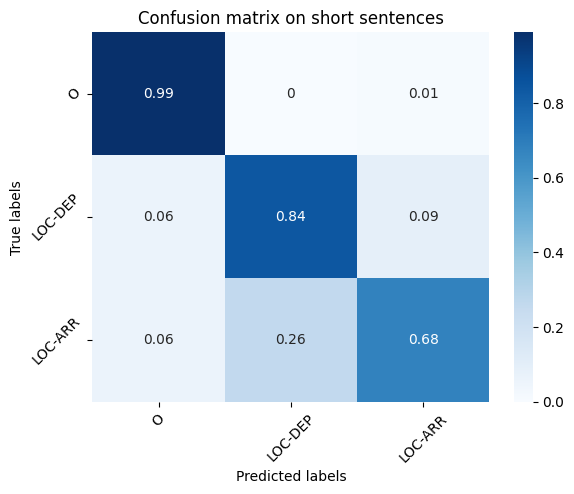

In [107]:
lstm_with_pos_eval_short_predictions = lstm_with_pos.predict(
    [encoded_eval_short_sentences, encoded_eval_short_sentences_pos_array]
)

confusion_matrix(
    padded_eval_short_labels,
    lstm_with_pos_eval_short_predictions,
    unique_labels,
    title="Confusion matrix on short sentences",
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
(100, 100)


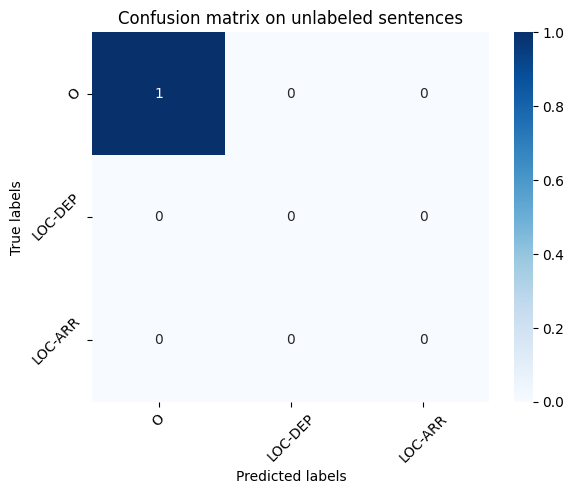

In [49]:
encoded_eval_unlabeled_sentences_pos_array = np.array(
    encoded_eval_unlabeled_sentences_pos
)

lstm_with_pos_eval_unlabeled_predictions = lstm_with_pos.predict(
    [encoded_eval_unlabeled_sentences, encoded_eval_unlabeled_sentences_pos_array]
)

confusion_matrix(
    padded_eval_unlabeled_labels,
    lstm_with_pos_eval_unlabeled_predictions,
    unique_labels,
    title="Confusion matrix on unlabeled sentences",
)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(96, 100)


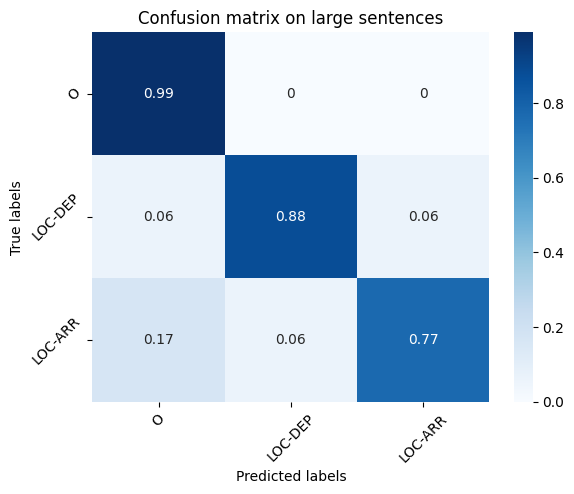

In [108]:
encoded_eval_large_sentences_pos_array = np.array(encoded_eval_large_sentences_pos)

lstm_with_pos_eval_large_predictions = lstm_with_pos.predict(
    [encoded_eval_large_sentences, encoded_eval_large_sentences_pos_array]
)

confusion_matrix(
    padded_eval_large_labels,
    lstm_with_pos_eval_large_predictions,
    unique_labels,
    title="Confusion matrix on large sentences",
)

In [ ]:
lstm_with_pos_results = bootstrap_evaluation(
    lstm_with_pos, pos_sentences=bootstrap_eval_sentences_pos
)

100%|██████████| 30/30 [00:05<00:00,  5.39it/s]


In [ ]:
import pickle

with open("lstm_with_pos_results.pickle", "wb") as f:
    pickle.dump(lstm_with_pos_results, f)

### LSTM without POS


In [134]:
lstm = tf.keras.models.Sequential(
    layers=[
        tf.keras.layers.Embedding(len(vocab) + 1, MAX_LEN, mask_zero=True),
        tf.keras.layers.LSTM(MAX_LEN, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(unique_labels), activation=tf.nn.log_softmax),
    ]
)

In [137]:
lstm.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=masked_loss,
    metrics=[entity_accuracy],
)

In [138]:
lstm.fit(
    train_dataset.batch(64),
    validation_data=test_dataset.batch(64),
    epochs=10,
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", min_delta=0.01, restore_best_weights=True
        )
    ],
)

Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - entity_accuracy: 0.9696 - loss: 0.0147 - val_entity_accuracy: 0.9146 - val_loss: 0.0274
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - entity_accuracy: 0.9857 - loss: 0.0062 - val_entity_accuracy: 0.9782 - val_loss: 0.0099
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - entity_accuracy: 0.9940 - loss: 0.0023 - val_entity_accuracy: 0.9816 - val_loss: 0.0120


In [139]:
test_predictions = lstm.predict(test_dataset.batch(1))

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step


In [140]:
eval_short_predictions = lstm.predict(encoded_eval_short_sentences)
eval_unlabeled_predictions = lstm.predict(encoded_eval_unlabeled_sentences)
eval_large_predictions = lstm.predict(encoded_eval_large_sentences)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [141]:
print(
    "Eval short sentences accuracy: ",
    masked_accuracy(padded_eval_short_labels, eval_short_predictions).numpy(),
)
print(
    "Eval unlabeled sentences accuracy: ",
    masked_accuracy(padded_eval_unlabeled_labels, eval_unlabeled_predictions).numpy(),
)
print(
    "Eval large sentences accuracy: ",
    masked_accuracy(padded_eval_large_labels, eval_large_predictions).numpy(),
)

Eval short sentences accuracy:  0.93448687
Eval unlabeled sentences accuracy:  0.99549145
Eval large sentences accuracy:  0.9792176


The accuracy of the `large_sentences` corpus is much higher than the `short_sentences` but that is influenced by the **higher** number of `O` tags and doesn't reflect the actual accuracy of **entities recognition**.


In [142]:
print(
    "Eval short sentences tag accuracy: ",
    entity_accuracy(padded_eval_short_labels, eval_short_predictions).numpy(),
)
print(
    "Eval large sentences tag accuracy: ",
    entity_accuracy(padded_eval_large_labels, eval_large_predictions).numpy(),
)

Eval short sentences tag accuracy:  0.7413793
Eval large sentences tag accuracy:  0.7351598


In [144]:
tf.math.argmax(eval_short_predictions, axis=-1)

<tf.Tensor: shape=(757, 100), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>

In [145]:
padded_eval_short_labels.flatten()

array([ 0,  0,  0, ..., -1, -1, -1], dtype=int32)

In [146]:
from sklearn.metrics import f1_score

f1_score(
    padded_eval_short_labels.flatten(),
    tf.math.argmax(eval_short_predictions, axis=-1).numpy().flatten(),
    average="micro",
    labels=[1, 2],
)

0.7738132174992243

(757, 100)
(100, 100)
(95, 100)


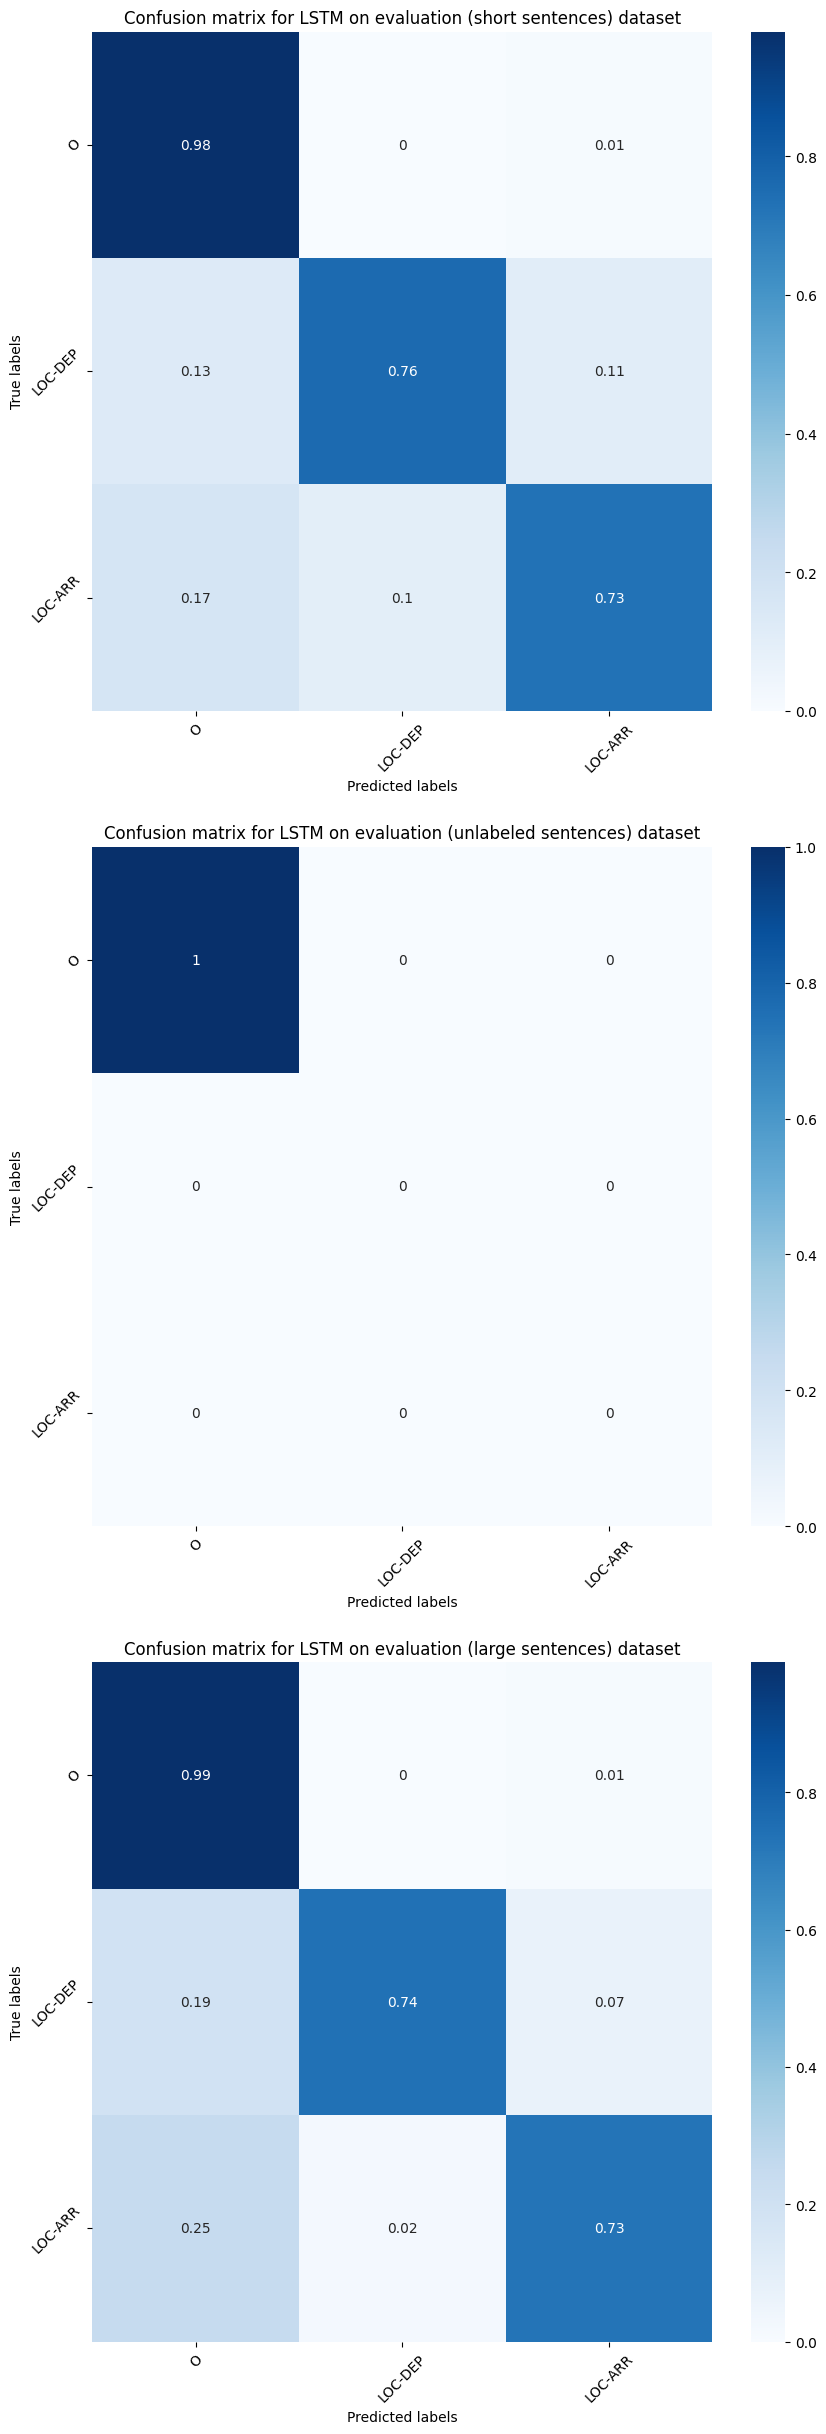

In [147]:
fig, axs = plt.subplots(3, 1, figsize=(10, 30))

confusion_matrix(
    padded_eval_short_labels,
    eval_short_predictions,
    unique_labels,
    title="Confusion matrix for LSTM on evaluation (short sentences) dataset",
    return_ax=True,
    ax=axs[0],
)

confusion_matrix(
    padded_eval_unlabeled_labels,
    eval_unlabeled_predictions,
    unique_labels,
    title="Confusion matrix for LSTM on evaluation (unlabeled sentences) dataset",
    return_ax=True,
    ax=axs[1],
)

confusion_matrix(
    padded_eval_large_labels,
    eval_large_predictions,
    unique_labels,
    title="Confusion matrix for LSTM on evaluation (large sentences) dataset",
    return_ax=True,
    ax=axs[2],
)

plt.show()

In [24]:
def predict(
    sentence: str,
    model: tf.keras.Model,
    vocab: list[str] = vocab,
    max_len: int = MAX_LEN,
):
    """
    Predict the labels for a given sentence.

    Parameters:
    sentence (str): The sentence to predict.
    model (tf.keras.Model): The trained model.
    vocab (list): The vocabulary.
    max_len (int): The maximum length of the sentence.

    Returns:
    list: The predicted labels.
    """
    processed_sentence = dp.process_sentence(
        sentence, stemming=True, return_tokens=True
    )

    unstemmed_sentence = dp.process_sentence(
        sentence, stemming=False, return_tokens=True
    )

    encoded_sentence = encode_and_pad_sentence(processed_sentence, vocab, max_len)

    prediction = model.predict(tf.convert_to_tensor([encoded_sentence]))

    for word, label in zip(
        unstemmed_sentence, tf.math.argmax(prediction, axis=-1)[0].numpy()
    ):
        print(f"{word}: {list(unique_labels.keys())[label]}")

    return prediction

In [148]:
lstm_results = bootstrap_evaluation(lstm)

100%|██████████| 30/30 [00:10<00:00,  2.73it/s]


In [ ]:
import pickle

with open("lstm_results.pickle", "wb") as f:
    pickle.dump(lstm_results, f)

In [153]:
test_sentence = (
    "J'ai passé de belles vacances à Paris. C'est l'heure de rentrer à Montpellier."
)

test_pred = predict(test_sentence, lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
J'ai: O
passé: O
de: O
belles: O
vacances: O
à: O
Paris: O
.: O
C'est: O
l'heure: O
de: O
rentrer: O
à: O
Montpellier: O
.: O


### Comparison


In [307]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

df_lstm_results = pd.DataFrame(lstm_results)
df_lstm_with_pos_results = pd.DataFrame(lstm_with_pos_results)

fig = go.Figure()

fig.add_trace(
    go.Box(
        y=df_lstm_results["f1_scores"],
        name="LSTM",
        boxmean=True,
        boxpoints="all",
        marker=dict(color="blue"),
    )
)

fig.add_trace(
    go.Box(
        y=df_lstm_with_pos_results["f1_scores"],
        name="LSTM with POS",
        boxmean=True,
        boxpoints="all",
        marker=dict(color="red"),
    )
)

fig.update_layout(title="F1-scores for LSTM vs LSTM with POS")

fig.show()

### Conclusion of using LSTM

The limitation of a simple LSTM is that the inputs are treated **sequentially**. Which means that it does not benefit from the context of the words that comes after, only what comes before. Therefore, we will try the **BiLSTM model** hoping that treating the sentence from both sides will leverage more context.


## BiLSTM

As mentioned in the previous section, we will be testing a **Bidirectional LSTM** model in order to improve performance.


![](./assets/bi-lstm.png)


### BiLSTM without POS


In [146]:
bilstm = tf.keras.models.Sequential(
    layers=[
        tf.keras.layers.Embedding(len(vocab) + 1, MAX_LEN, mask_zero=True),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(MAX_LEN, return_sequences=True)
        ),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(len(unique_labels), activation=tf.nn.log_softmax),
    ]
)

In [147]:
bilstm.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=masked_loss,
    metrics=[masked_accuracy],
)

In [148]:
bilstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         499300    
                                                                 
 bidirectional (Bidirection  (None, None, 200)         160800    
 al)                                                             
                                                                 
 dropout_160 (Dropout)       (None, None, 200)         0         
                                                                 
 dense (Dense)               (None, None, 3)           603       
                                                                 
Total params: 660703 (2.52 MB)
Trainable params: 660703 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [149]:
bilstm.fit(
    train_dataset.batch(64),
    validation_data=test_dataset.batch(64),
    epochs=10,
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", min_delta=0.01, restore_best_weights=True
        )
    ],
)

Epoch 1/10
149/149 [==============================] - 15s 80ms/step - loss: 0.0866 - masked_accuracy: 0.9744 - val_loss: 0.0119 - val_masked_accuracy: 0.9961
Epoch 2/10
149/149 [==============================] - 11s 73ms/step - loss: 0.0023 - masked_accuracy: 0.9994 - val_loss: 0.0023 - val_masked_accuracy: 0.9995


In [150]:
blstm_eval_short_predictions = bilstm.predict(encoded_eval_short_sentences)
blstm_eval_unlabeled_predictions = bilstm.predict(encoded_eval_unlabeled_sentences)
blstm_eval_large_predictions = bilstm.predict(encoded_eval_large_sentences)

3/3 [==============================] - 0s 13ms/step


In [151]:
bilstm_results = bootstrap_evaluation(bilstm)

100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


In [161]:
import pickle

with open("bilstm_results.pickle", "wb") as f:
    pickle.dump(bilstm_results, f)

(758, 100)


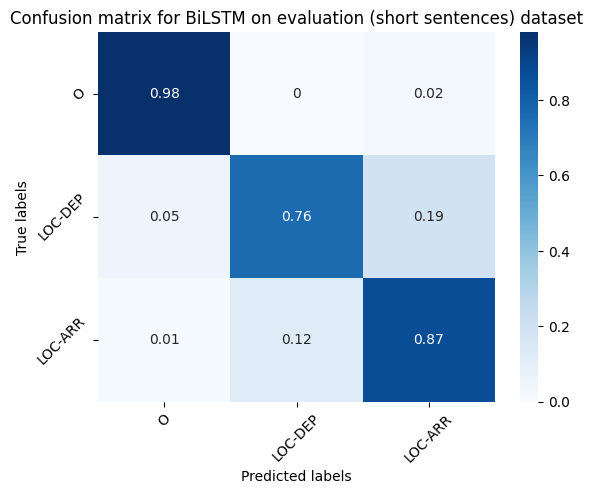

In [168]:
confusion_matrix(
    padded_eval_short_labels,
    blstm_eval_short_predictions,
    unique_labels,
    title="Confusion matrix for BiLSTM on evaluation (short sentences) dataset",
)

(100, 100)


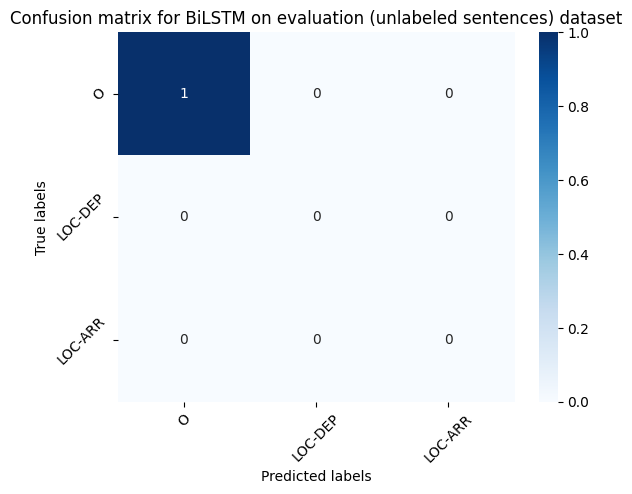

In [169]:
confusion_matrix(
    padded_eval_unlabeled_labels,
    blstm_eval_unlabeled_predictions,
    unique_labels,
    title="Confusion matrix for BiLSTM on evaluation (unlabeled sentences) dataset",
)

(96, 100)


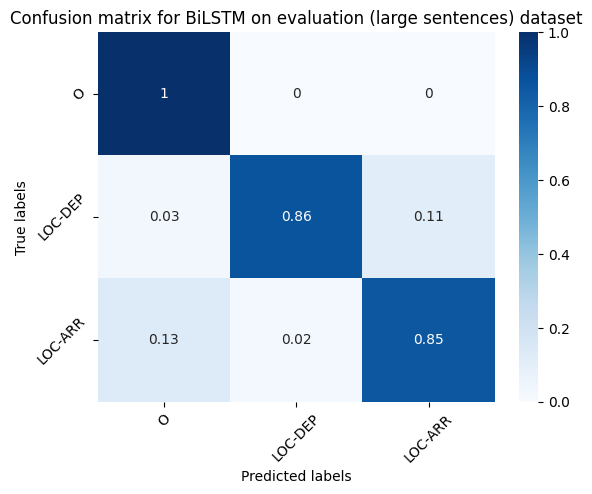

In [170]:
confusion_matrix(
    padded_eval_large_labels,
    blstm_eval_large_predictions,
    unique_labels,
    title="Confusion matrix for BiLSTM on evaluation (large sentences) dataset",
)

In [47]:
test_sentence = "Je pensais partir de Bangkok. Mais finalement, je vais devoir trouver un voyage de Tokyo vers Osaka."


p = predict(test_sentence, bilstm)

NameError: name 'predict' is not defined

### BiLSTM with POS


In [ ]:
bilstm_word_input = tf.keras.layers.Input(shape=(MAX_LEN,), name="bilstm_word_input")
bilstm_pos_input = tf.keras.layers.Input(shape=(MAX_LEN,), name="bilstm_pos_input")

emb_size = 64

bilstm_word_embedding = tf.keras.layers.Embedding(
    len(vocab), emb_size, name="bilstm_word_embedding"
)(bilstm_word_input)

bilstm_pos_embedding = tf.keras.layers.Embedding(
    len(unique_pos_tags),
    emb_size,
    name="bilstm_pos_embedding",
)(bilstm_pos_input)

bilstm_concatenated = tf.keras.layers.Concatenate()(
    [bilstm_word_embedding, bilstm_pos_embedding]
)

bilstm_masked_cat = tf.keras.layers.Masking(mask_value=0)(bilstm_concatenated)

bilstm_layer_with_pos = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(MAX_LEN, return_sequences=True), name="bilstm_layer"
)(bilstm_masked_cat)

bilstm_dropout = tf.keras.layers.Dropout(0.2)(bilstm_layer_with_pos)

bilstm_output = tf.keras.layers.Dense(len(unique_labels), activation=tf.nn.log_softmax)(
    bilstm_dropout
)

bilstm_with_pos = tf.keras.Model(
    inputs=[bilstm_word_input, bilstm_pos_input], outputs=bilstm_output
)

bilstm_with_pos.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=masked_loss,
    metrics=[entity_accuracy],
)

In [309]:
bilstm_with_pos.fit(
    pos_train_dataset.batch(32),
    validation_data=pos_test_dataset.batch(32),
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", min_delta=0.01, restore_best_weights=True
        )
    ],
)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - entity_accuracy: 0.7609 - loss: 0.1435 - val_entity_accuracy: 0.9983 - val_loss: 0.0027
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - entity_accuracy: 0.9953 - loss: 0.0036 - val_entity_accuracy: 0.9990 - val_loss: 7.3262e-04


In [ ]:
bilstm_with_pos_results = bootstrap_evaluation(
    bilstm_with_pos, pos_sentences=bootstrap_eval_sentences_pos
)

100%|██████████| 30/30 [00:23<00:00,  1.25it/s]


### Comparison


In [311]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

df_bilstm_results = pd.DataFrame(bilstm_results)
df_bilstm_with_pos_results = pd.DataFrame(bilstm_with_pos_results)

fig = go.Figure()

fig.add_trace(
    go.Box(
        y=df_bilstm_results["f1_scores"],
        name="BiLSTM",
        boxmean=True,
        boxpoints="all",
        marker=dict(color="blue"),
    )
)

fig.add_trace(
    go.Box(
        y=df_bilstm_with_pos_results["f1_scores"],
        name="BiLSTM with POS",
        boxmean=True,
        boxpoints="all",
        marker=dict(color="red"),
    )
)

fig.update_layout(title="F1-scores for BiLSTM vs BiLSTM with POS")

fig.show()

## CamemBERT


The model used will be the fine-tuned version of [CamemBERT](https://huggingface.co/almanach/camembert-base) which is a state-of-the-art language model for French text.

The model has been fine-tuned for our task [in here](./camemBERT_finetuning.ipynb) and saved on Hugging Face for convenience.

[Checkout the model on Huggingface Hub](https://huggingface.co/Az-r-ow/CamemBERT-NER-Travel)


In [91]:
import tensorflow as tf
from transformers import TFCamembertForTokenClassification, CamembertTokenizerFast
import numpy as np

tokenizer = CamembertTokenizerFast.from_pretrained("cmarkea/distilcamembert-base")

camembert = TFCamembertForTokenClassification.from_pretrained(
    "./models/distilcamembert-base-ner-cross-entropy-11", num_labels=len(unique_labels)
)

Some layers from the model checkpoint at ./models/distilcamembert-base-ner-cross-entropy-11 were not used when initializing TFCamembertForTokenClassification: ['dropout_39']
- This IS expected if you are initializing TFCamembertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFCamembertForTokenClassification were initialized from the model checkpoint at ./models/distilcamembert-base-ner-cross-entropy-11.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForTokenClassification for predictions without further training.

In [121]:
tokenized_eval_short_sentences = tokenizer(
    eval_sentences,
    return_tensors="tf",
    padding="max_length",
    max_length=150,
)

tokenized_eval_unlabeled_sentences = tokenizer(
    eval_unlabeled, return_tensors="tf", padding="max_length", max_length=150
)

tokenized_eval_large_sentences = tokenizer(
    eval_large,
    return_tensors="tf",
    truncation=True,
    padding="max_length",
    max_length=150,
)

In [99]:
camembert_short_sentences_predictions = camembert.predict(
    tokenized_eval_short_sentences
)

24/24 [==============================] - 34s 1s/step


In [100]:
tf.argmax(camembert_short_sentences_predictions.logits, axis=-1)[0]

<tf.Tensor: shape=(150,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])>

In [95]:
test_sentence = "Je veux partir de Paris à Montpellier."

tokenized_test_sentence = tokenizer(
    test_sentence, return_tensors="tf", padding="max_length", max_length=MAX_LEN
)

camembert_test_sentence_predictions = camembert.predict(tokenized_test_sentence)

tf.math.argmax(camembert_test_sentence_predictions.logits, axis=-1)

1/1 [==============================] - 0s 51ms/step


<tf.Tensor: shape=(1, 100), dtype=int64, numpy=
array([[0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])>

In [59]:
def align_labels_with_tokens(encodings, labels):
    """
    Aligns the labels to match the tokenized outputs.

    Args:
        encodings (BatchEncoding): Tokenized outputs from the Hugging Face tokenizer (must use a fast tokenizer).
        labels (List[List[int]]): Original labels for each sentence before tokenization. Each inner list corresponds to one sentence.

    Returns:
        List[List[int]]: Aligned labels, where each inner list corresponds to the aligned labels for the tokenized sentence.
                         Special tokens and padding are assigned a value of -100.
    """
    adapted_labels = []

    for i, label in enumerate(labels):
        word_ids = encodings.word_ids(
            batch_index=i
        )  # Get word IDs for the i-th sentence
        aligned_labels = []
        previous_word_id = None

        for word_id in word_ids:
            if word_id is None:
                # Special tokens (e.g., [CLS], [SEP], or padding)
                aligned_labels.append(-100)
            elif word_id != previous_word_id:
                # New word
                aligned_labels.append(label[word_id])
            else:
                # Subword token (same word)
                aligned_labels.append(
                    label[word_id]
                )  # Or append -100 to ignore subwords
            previous_word_id = word_id

        adapted_labels.append(aligned_labels)

    return adapted_labels

In [101]:
aligned_eval_short_labels = align_labels_with_tokens(
    tokenized_eval_short_sentences, padded_eval_short_labels
)

In [119]:
aligned_eval_long_labels = align_labels_with_tokens(
    tokenized_eval_large_sentences, padded_eval_large_labels
)

In [ ]:
type(tokenized_eval_large_sentences)

num_sentences = tokenized_eval_short_sentences["input_ids"].shape[0]

indicies = tf.random.uniform([num_sentences], maxval=num_sentences, dtype=tf.int32)

sampled_input_ids = tf.gather(tokenized_eval_short_sentences["input_ids"], indicies)
sampled_attention_mask = tf.gather(
    tokenized_eval_short_sentences["attention_mask"], indicies
)

In [124]:
aligned_eval_unlabeled_labels = align_labels_with_tokens(
    tokenized_eval_unlabeled_sentences, padded_eval_unlabeled_labels
)

(758, 150)


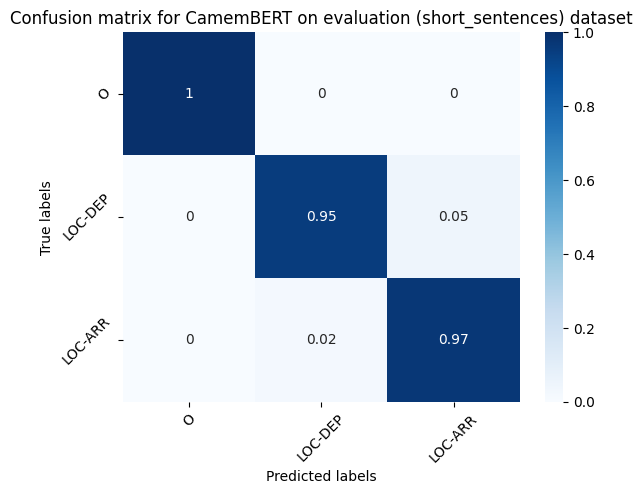

In [171]:
confusion_matrix(
    aligned_eval_short_labels,
    camembert_short_sentences_predictions.logits,
    unique_labels,
    title="Confusion matrix for CamemBERT on evaluation (short_sentences) dataset",
)

In [117]:
camembert_large_sentences_predictions = camembert.predict(
    tokenized_eval_large_sentences
)

3/3 [==============================] - 4s 1s/step


(96, 150)


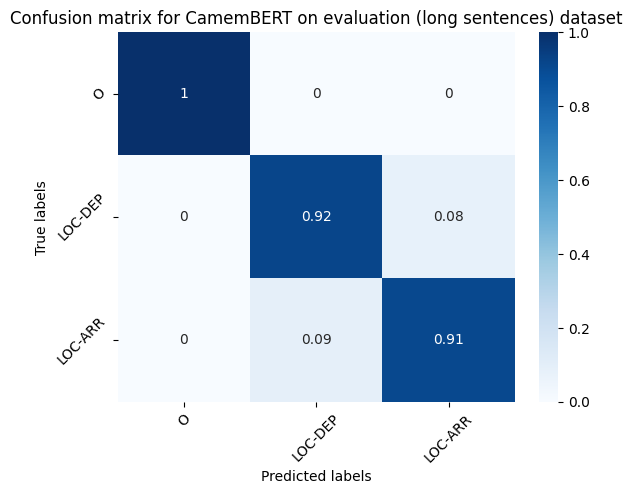

In [174]:
confusion_matrix(
    aligned_eval_long_labels,
    camembert_large_sentences_predictions.logits,
    unique_labels,
    title="Confusion matrix for CamemBERT on evaluation (long sentences) dataset",
)

In [123]:
camembert_unlabeled_sentence_predictions = camembert.predict(
    tokenized_eval_unlabeled_sentences
)

4/4 [==============================] - 4s 924ms/step


(100, 150)


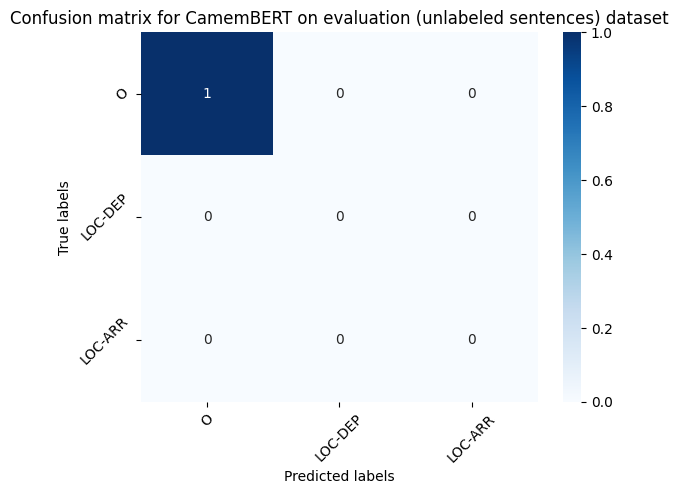

In [172]:
confusion_matrix(
    aligned_eval_unlabeled_labels,
    camembert_unlabeled_sentence_predictions.logits,
    unique_labels,
    title="Confusion matrix for CamemBERT on evaluation (unlabeled sentences) dataset",
)

In [188]:
camembert_eval_sentences = eval_sentences + eval_unlabeled + eval_large
camembert_eval_labels = np.concatenate(
    [padded_eval_short_labels, padded_eval_unlabeled_labels, padded_eval_large_labels]
)

In [189]:
camembert_eval_sentences_tokenized = tokenizer(
    camembert_eval_sentences, return_tensors="tf", padding="max_length", max_length=150
)

camembert_eval_labels_aligned = align_labels_with_tokens(
    camembert_eval_sentences_tokenized, camembert_eval_labels
)

In [248]:
len(camembert_eval_labels_aligned)

954

In [244]:
camembert_results = bootstrap_evaluation(
    camembert,
    sentences=camembert_eval_sentences_tokenized,
    labels=camembert_eval_labels_aligned,
    from_logits=True,
    has_mask=True
    num_bootstrap_samples=1,
)

100%|██████████| 1/1 [00:42<00:00, 42.16s/it]


In [245]:
camembert_results["f1_scores"]

[0.2422770593488873]

## Prediction Analysis


In [79]:
from tqdm import tqdm
import pandas as pd
import numpy as np


def mask_predictions(predictions: np.ndarray, labels: np.ndarray, mask=-1):
    """
    Mask the predictions based on the labels.

    Parameters:
    predictions (tensor): Predicted logits.
    labels (tensor): True labels.
    mask (int): Mask value.

    Returns:
    masked_predictions (tensor): Masked predictions.
    """

    # Perform argmax to get the predicted values
    predictions_class = np.argmax(predictions, axis=-1)

    # Create the mask based on the mask in the labels
    mask = np.where(labels == mask, mask, 0)
    return predictions_class + mask


def get_mistakes_positions(predictions, labels):
    masked_predictions = mask_predictions(predictions, labels)
    wrong_predictions = np.where(masked_predictions != labels, masked_predictions, -2)
    return wrong_predictions


def plot_mistakes_positions(
    predictions, labels, title="Mistakes density in sentences", max_len=None
):
    mistakes_positions = get_mistakes_positions(predictions, labels)
    mistakes_positions = np.where(mistakes_positions >= 0, 1, 0)
    mistakes_positions = np.sum(mistakes_positions, axis=0)
    mistakes_position_density = mistakes_positions / np.max(mistakes_positions)

    plt.figure(figsize=(20, 5))

    if max_len:
        mistakes_position_density = mistakes_position_density[:max_len]

    sns.heatmap(mistakes_position_density.reshape(1, -1), cmap="Blues")

    plt.title(title)
    plt.show()


def label_pos_freq_in_sentences(
    labels,
    unique_labels,
    title="Sentences labels heatmap",
    skip_zero_positions=False,
    max_len=None,
):
    """
    Generate a heatmap of the sentences and their labels.

    Parameters:
    labels (list): List of labels in a sentence (it could be predictions)
    unique_labels (list): List of unique labels.
    title (str): Title of the plot.
    """
    positions_label_counts = {}

    for label in tqdm(labels):
        length = max_len if max_len else len(label)
        for i in range(length):
            # skip padding
            if label[i] not in unique_labels.values() and not label[i] == -2:
                continue
            if i not in positions_label_counts:
                positions_label_counts[i] = {}
                for l in unique_labels.values():
                    positions_label_counts[i][l] = 0
            if label[i] == -2:
                continue
            positions_label_counts[i][label[i]] += 1

    # Filter out positions where the sum of label counts is zero
    hm_data = {
        k: v
        for k, v in positions_label_counts.items()
        if skip_zero_positions and sum(list(v.values())) > 0 or not skip_zero_positions
    }
    hm_data = pd.DataFrame(hm_data)

    # dtype conversion
    hm_data = hm_data.astype(float)
    hm_data.set_index(pd.Index(unique_labels.keys()), inplace=True)

    # normalizing the data per column
    hm_data = hm_data.div(hm_data.sum(axis=0), axis=1)

    plt.figure(figsize=(20, 10))

    sns.heatmap(hm_data, cmap="Blues")

    plt.title(title)

    plt.show()

100%|██████████| 757/757 [00:00<00:00, 3743.50it/s]


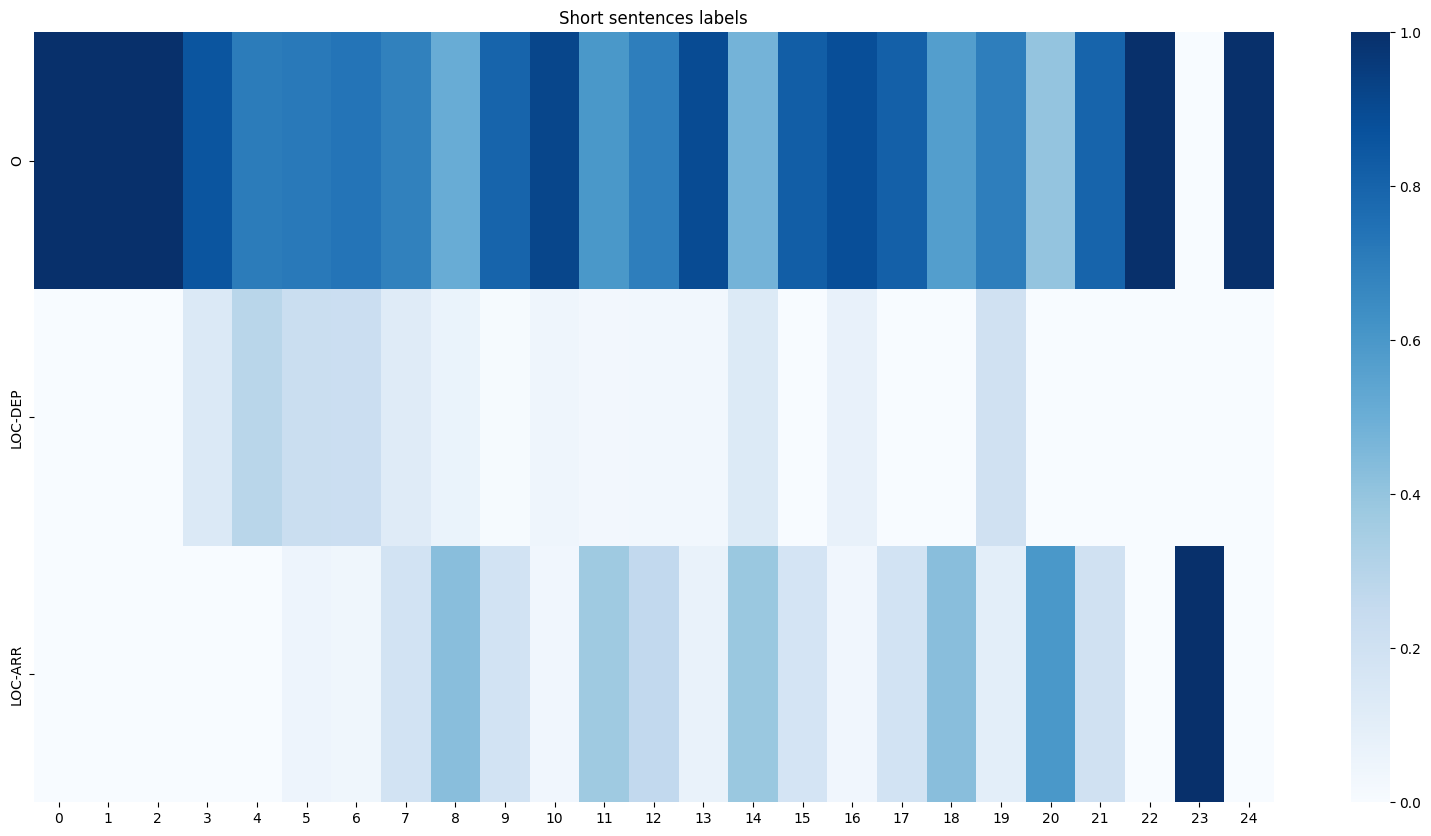

In [ ]:
label_pos_freq_in_sentences(
    padded_eval_short_labels, unique_labels, title="Short sentences labels"
)

100%|██████████| 757/757 [00:00<00:00, 36883.60it/s]


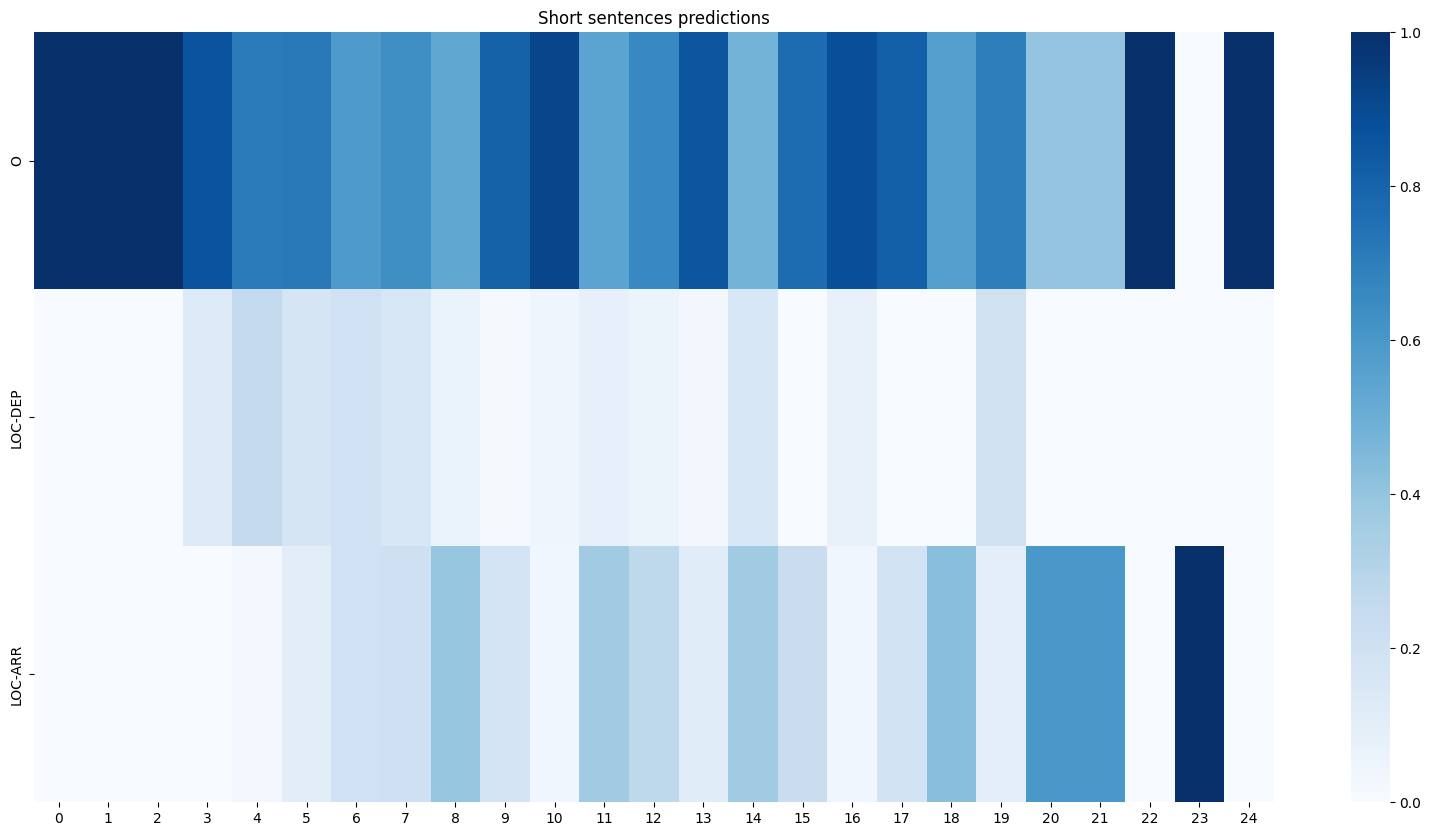

In [ ]:
label_pos_freq_in_sentences(
    mask_predictions(blstm_eval_short_predictions, padded_eval_short_labels),
    unique_labels,
    title="Short sentences predictions",
)

100%|██████████| 757/757 [00:00<00:00, 117731.03it/s]


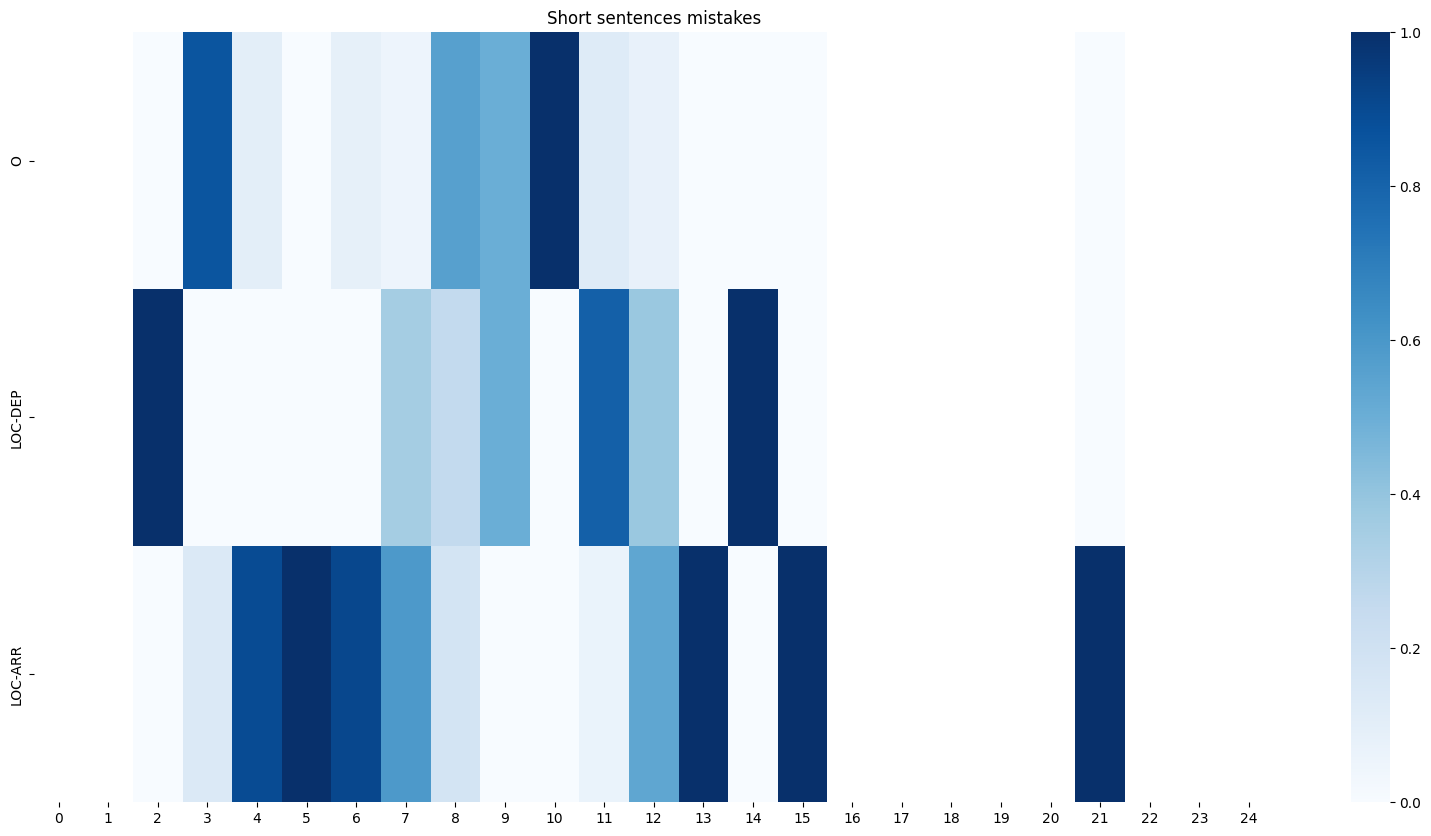

In [ ]:
label_pos_freq_in_sentences(
    get_mistakes_positions(blstm_eval_short_predictions, padded_eval_short_labels),
    unique_labels,
    title="Short sentences mistakes",
    max_len=25,
)

100%|██████████| 95/95 [00:00<00:00, 3243.09it/s]


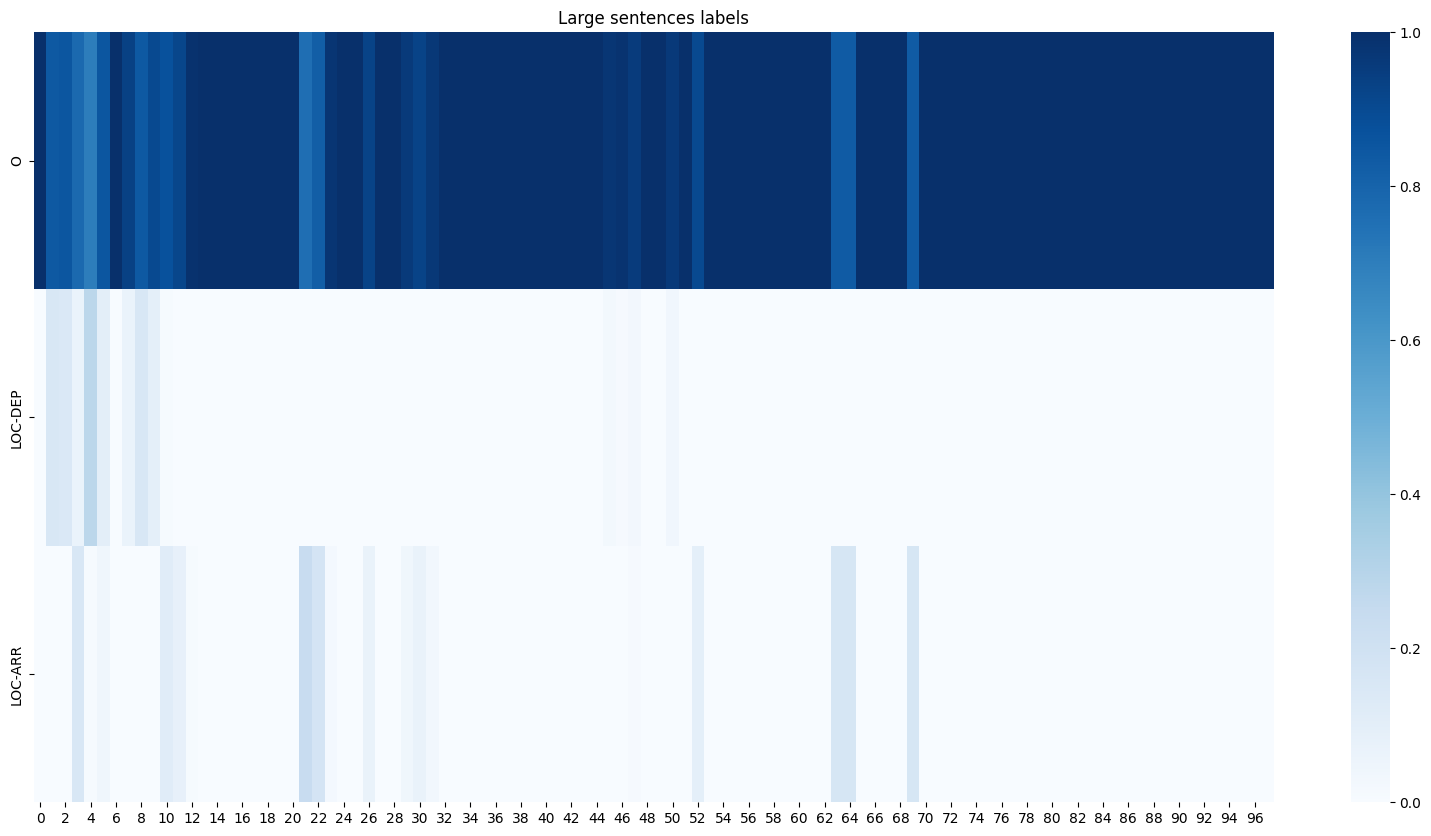

In [ ]:
label_pos_freq_in_sentences(
    padded_eval_large_labels, unique_labels, title="Large sentences labels"
)

100%|██████████| 95/95 [00:00<00:00, 29150.55it/s]


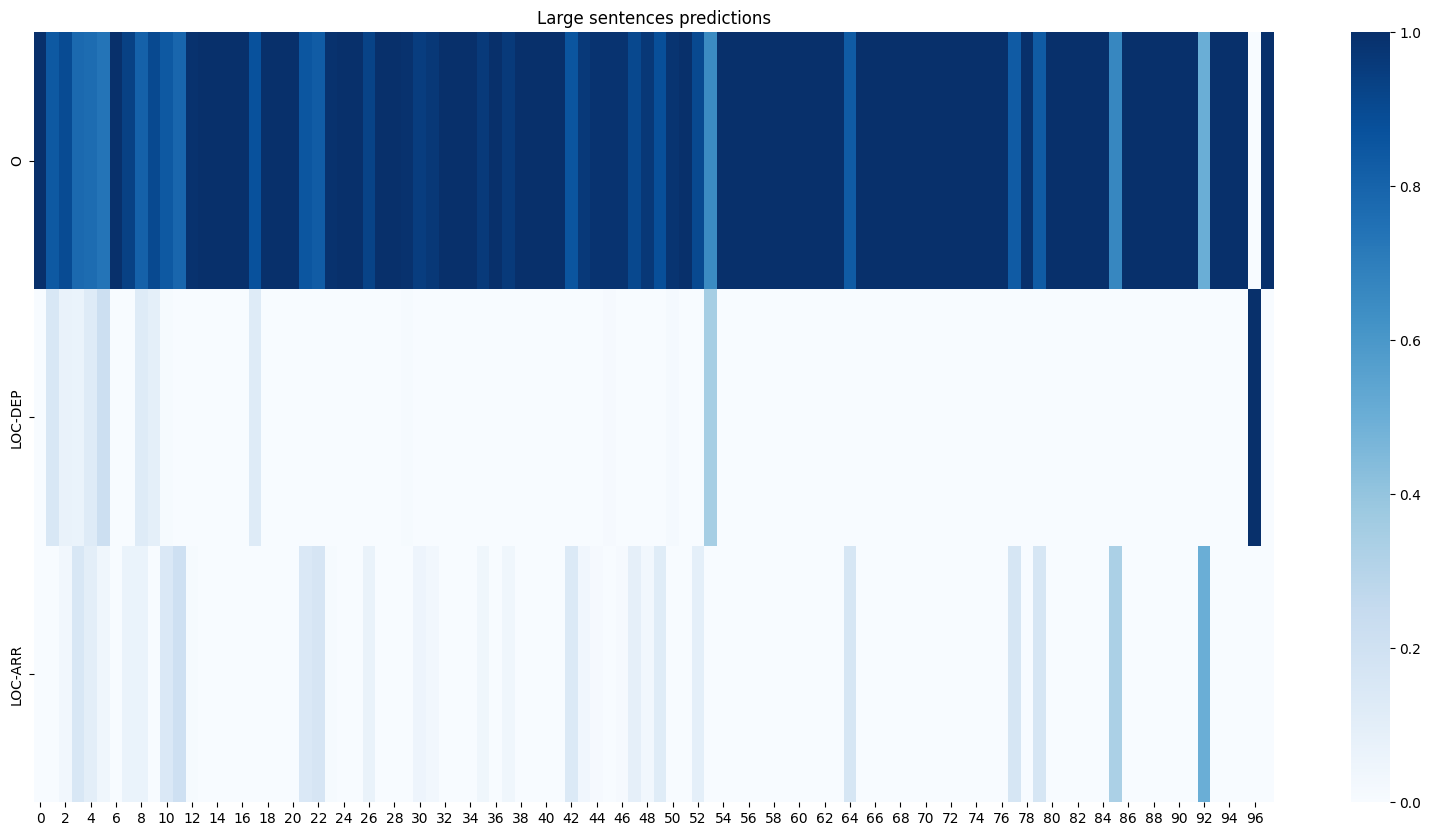

In [ ]:
label_pos_freq_in_sentences(
    mask_predictions(blstm_eval_large_predictions, padded_eval_large_labels),
    unique_labels,
    title="Large sentences predictions",
)

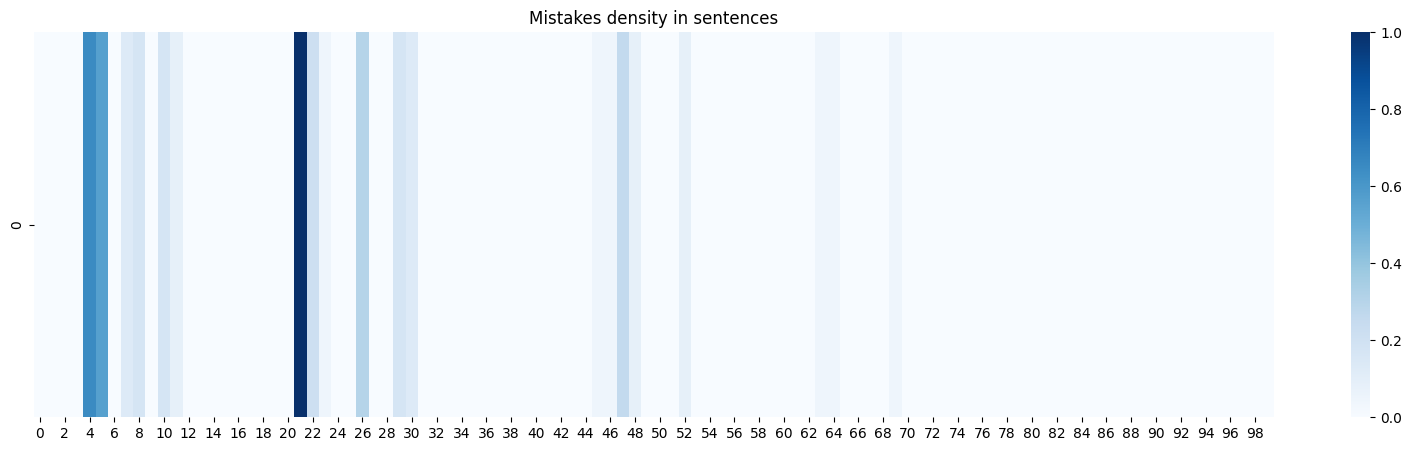

In [80]:
plot_mistakes_positions(blstm_eval_large_predictions, padded_eval_large_labels)

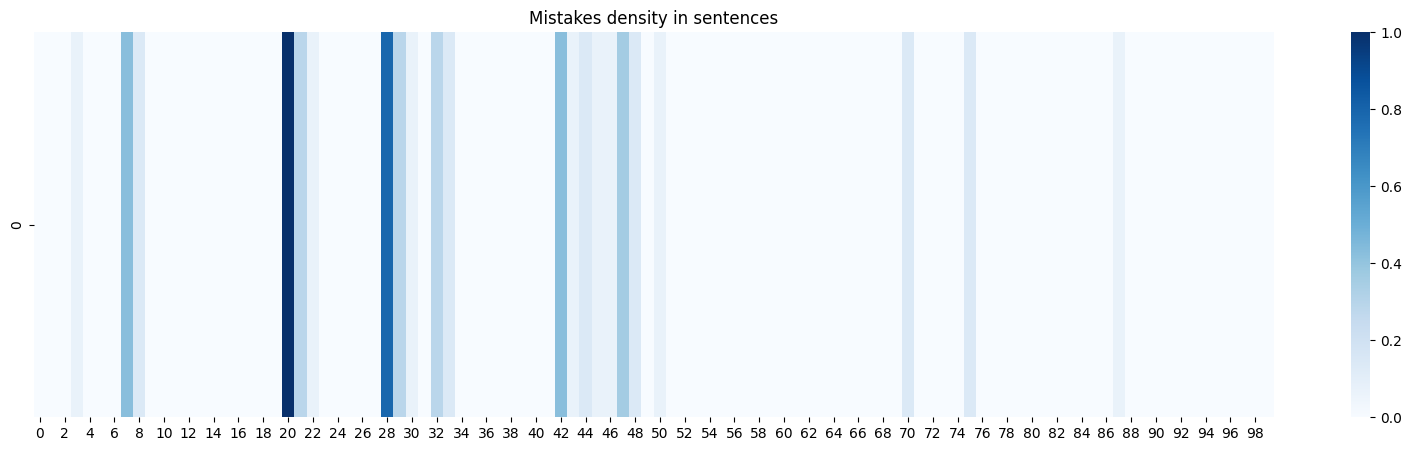

In [81]:
plot_mistakes_positions(lstm_with_pos_eval_large_predictions, padded_eval_large_labels)

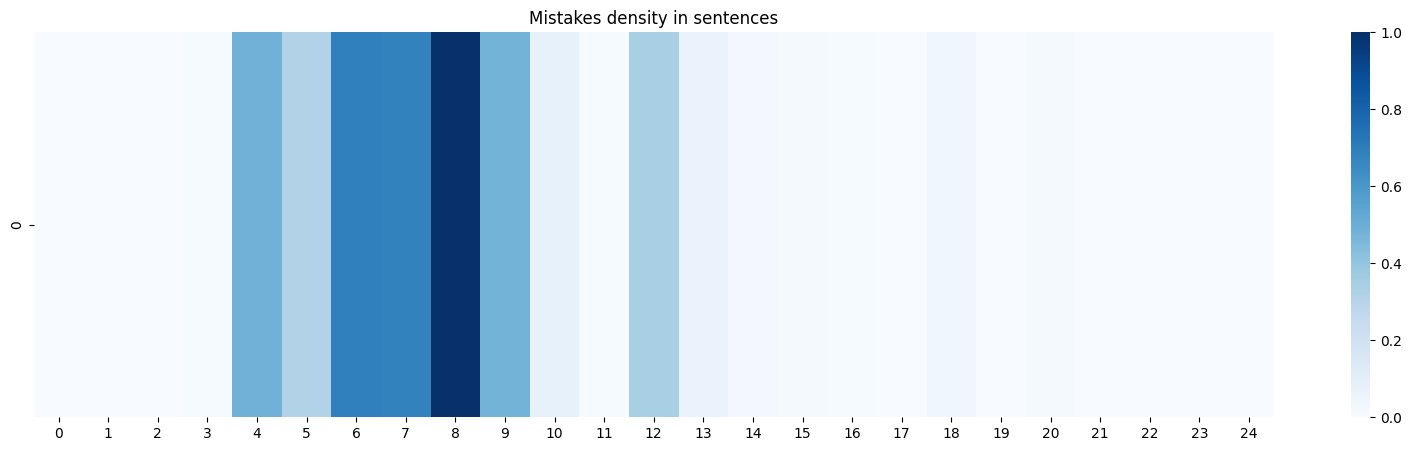

In [83]:
plot_mistakes_positions(
    lstm_with_pos_eval_short_predictions, padded_eval_short_labels, max_len=25
)

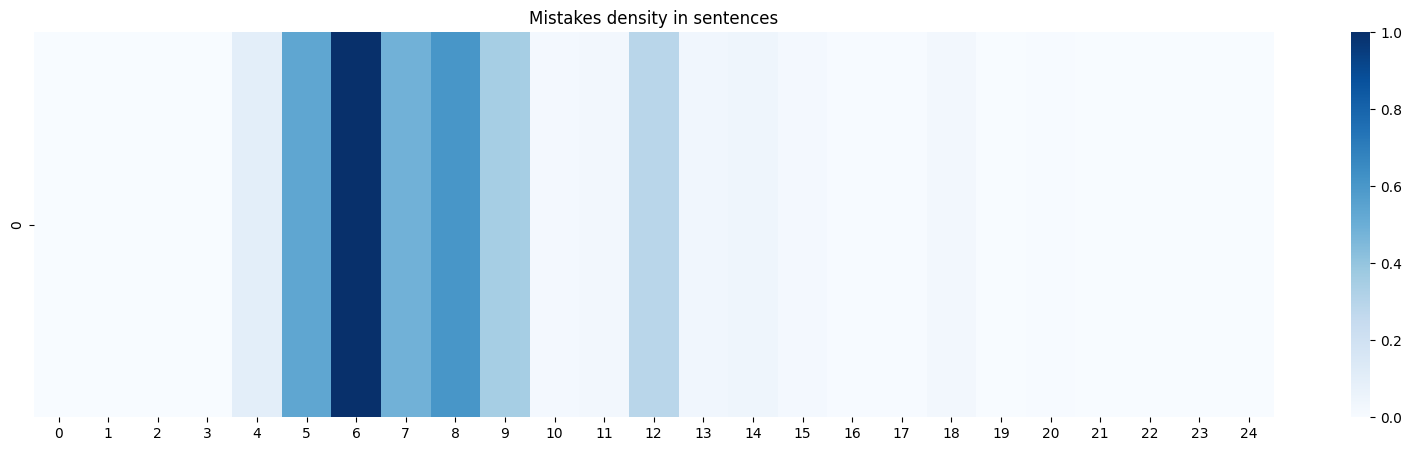

In [85]:
plot_mistakes_positions(
    blstm_eval_short_predictions, padded_eval_short_labels, max_len=25
)

100%|██████████| 95/95 [00:00<00:00, 27883.76it/s]


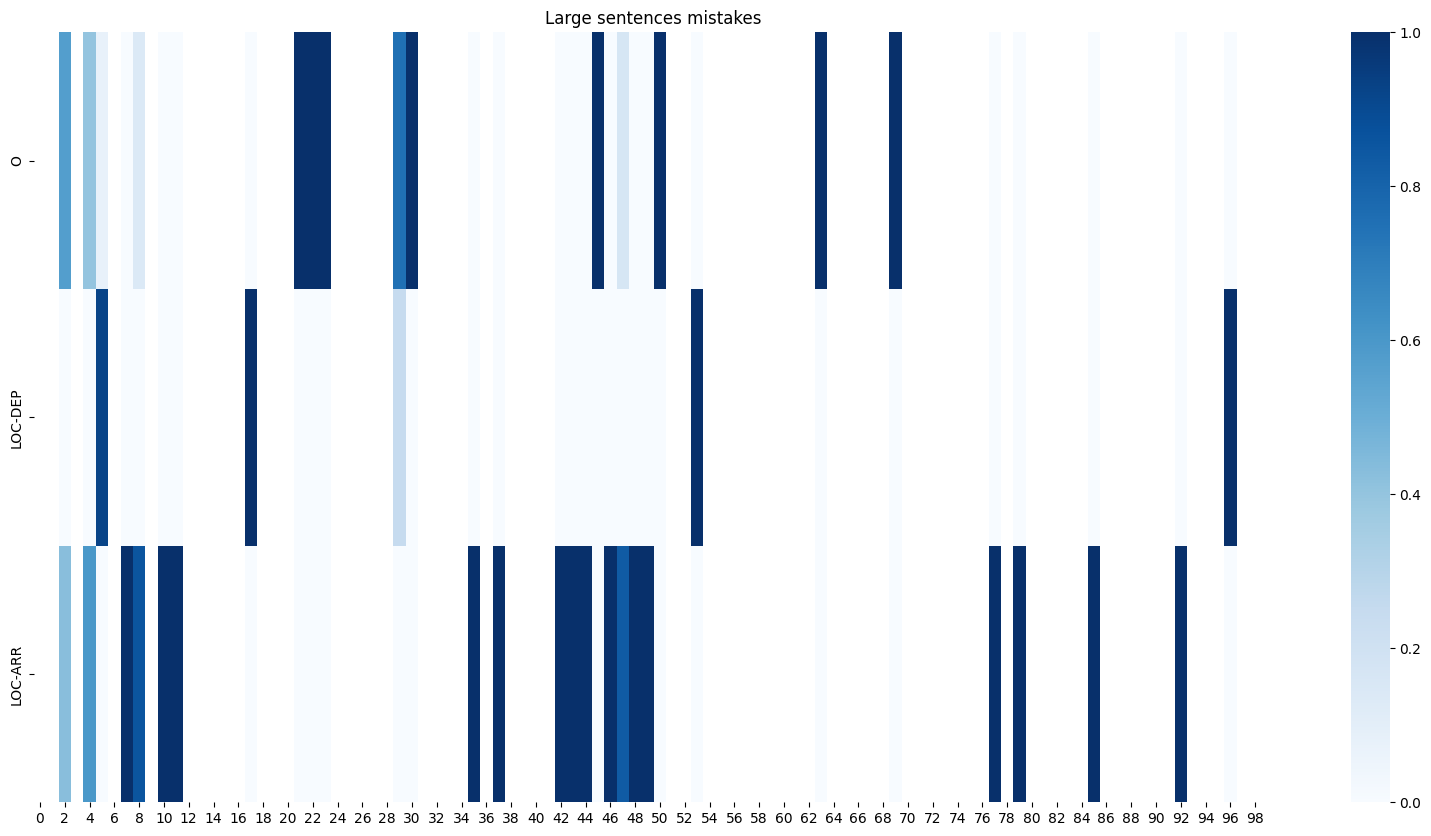

In [ ]:
label_pos_freq_in_sentences(
    get_mistakes_positions(blstm_eval_large_predictions, padded_eval_large_labels),
    unique_labels,
    title="Large sentences mistakes",
    skip_zero_positions=False,
)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

df_lstm_results = pd.DataFrame(lstm_results)
df_bilstm_results = pd.DataFrame(bilstm_results)

fig = go.Figure()

fig.add_trace(
    go.Box(
        y=df_lstm_results["accuracies"],
        name="LSTM",
        boxmean=True,
        boxpoints="all",
        marker=dict(color="blue"),
    )
)

fig.add_trace(
    go.Box(
        y=df_bilstm_results["accuracies"],
        name="BiLSTM",
        boxmean=True,
        boxpoints="all",
        marker=dict(color="red"),
    )
)

fig.update_layout(title="Accuracy distribution for LSTM and BiLSTM models")

fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Box(
        y=df_lstm_results["entity_accuracies"],
        name="LSTM",
        boxmean=True,
        boxpoints="all",
        marker=dict(color="blue"),
    )
)

fig.add_trace(
    go.Box(
        y=df_bilstm_results["entity_accuracies"],
        name="BiLSTM",
        boxmean=True,
        boxpoints="all",
        marker=dict(color="red"),
    )
)

fig.update_layout(title="Entity accuracy distribution for LSTM and BiLSTM models")

fig.show()